<a href="https://colab.research.google.com/github/ykt345/2019_Resnet50/blob/master/CNN_Final_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning and Visualization (CNN's)

Before beginning, let's load the appropriate libraries needed for this notebook

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

#### Model Creation

Next, let's load ResNet50 with just the convolutional layers and not the dense layers so we can train our new dataset on the new dense layers that we create

In [ ]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94773248/94765736 [==============================] - 2s 0us/step


Let's get an idea on how the ResNet architecture looks

In [ ]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

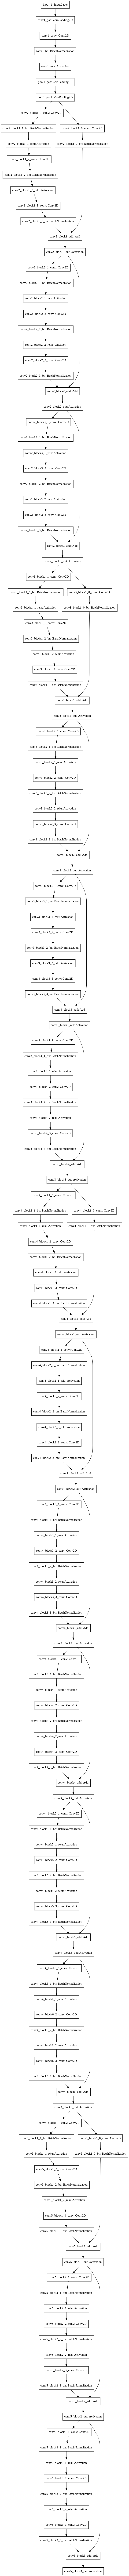

In [ ]:
from keras.utils import plot_model

keras.utils.plot_model(conv_base, to_file='model.png')

For the new dataset, let's work with the cifar10 dataset which we can load directly from keras' dataset library. The Cifar10 data description is as follows - "The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images"

*Changed the dataset*

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

print(x_train.shape)
print(x_test.shape)

 89333760/170498071 [==============>...............] - ETA: 3s

To train our model on the new dataset above, the architecture for everything besides the ResNet 50 portion has changed. To begin with, the input image of Cifar10 is 32x32 so it needs to be upscaled 3 times before we can pass it through the ResNet layers. After the images go through ResNet, we flatten our processed input and pass it though 2 dense layers (with 128 and 64 neurons respectively). Each layer has batch normalization beforehand and dropout coming out before the last layer, with softmax and 10 neurons. Since the method below is computationally expensive, let's only train it for 5 epochs which gives us a 98% training accuracy.

*Added layers and changed architecture*

*Retrained the model*

In [ ]:
model = models.Sequential()
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=5, batch_size=20, validation_data=(x_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 1925s 39ms/sample - loss: 0.2484 - acc: 0.9120 - val_loss: 0.1511 - val_acc: 0.9545
Epoch 2/5
50000/50000 [==============================] - 1914s 38ms/sample - loss: 0.1576 - acc: 0.9437 - val_loss: 0.0746 - val_acc: 0.9753
Epoch 3/5
50000/50000 [==============================] - 1914s 38ms/sample - loss: 0.1175 - acc: 0.9602 - val_loss: 0.0493 - val_acc: 0.9842
Epoch 4/5
50000/50000 [==============================] - 1907s 38ms/sample - loss: 0.0941 - acc: 0.9696 - val_loss: 0.0441 - val_acc: 0.9858
Epoch 5/5
50000/50000 [==============================] - 1915s 38ms/sample - loss: 0.0754 - acc: 0.9771 - val_loss: 0.0364 - val_acc: 0.9882


Let's save the model as an h5 file and load it bach so we don't need to retrain everytime

In [ ]:
model.save('my_model.h5')
del model
model = tf.keras.models.load_model('my_model.h5')

NameError: ignored

Next, let's evaluate our model on the test set. This yields a 98.79% accuracy

In [ ]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 23s 2ms/sample - loss: 0.0400 - acc: 0.9870


[0.040028155374526975, 0.98696995]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d (UpSampling2D) multiple                  0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 multiple                  0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 multiple                  0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
batch_normalization_v2 (Batc multiple                  524288    
_________________________________________________________________
dense (Dense)                multiple                  1

#### Visualization #1

The training/validation loss and accuracy visualizations are shown below

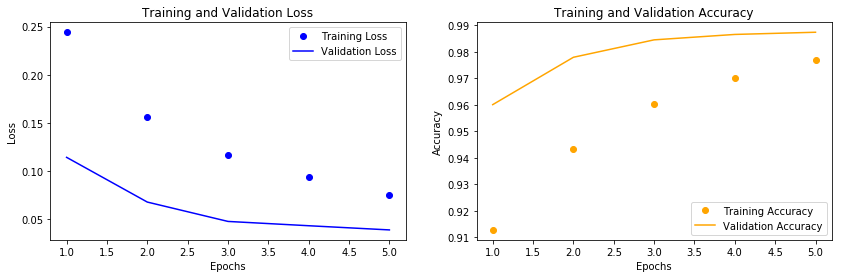

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss_values) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training Accuracy', c='orange')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#### Visualizing Intermediate Activations

#### Visualization #2

Let's take a look at how our images look before going into visualization techniques 

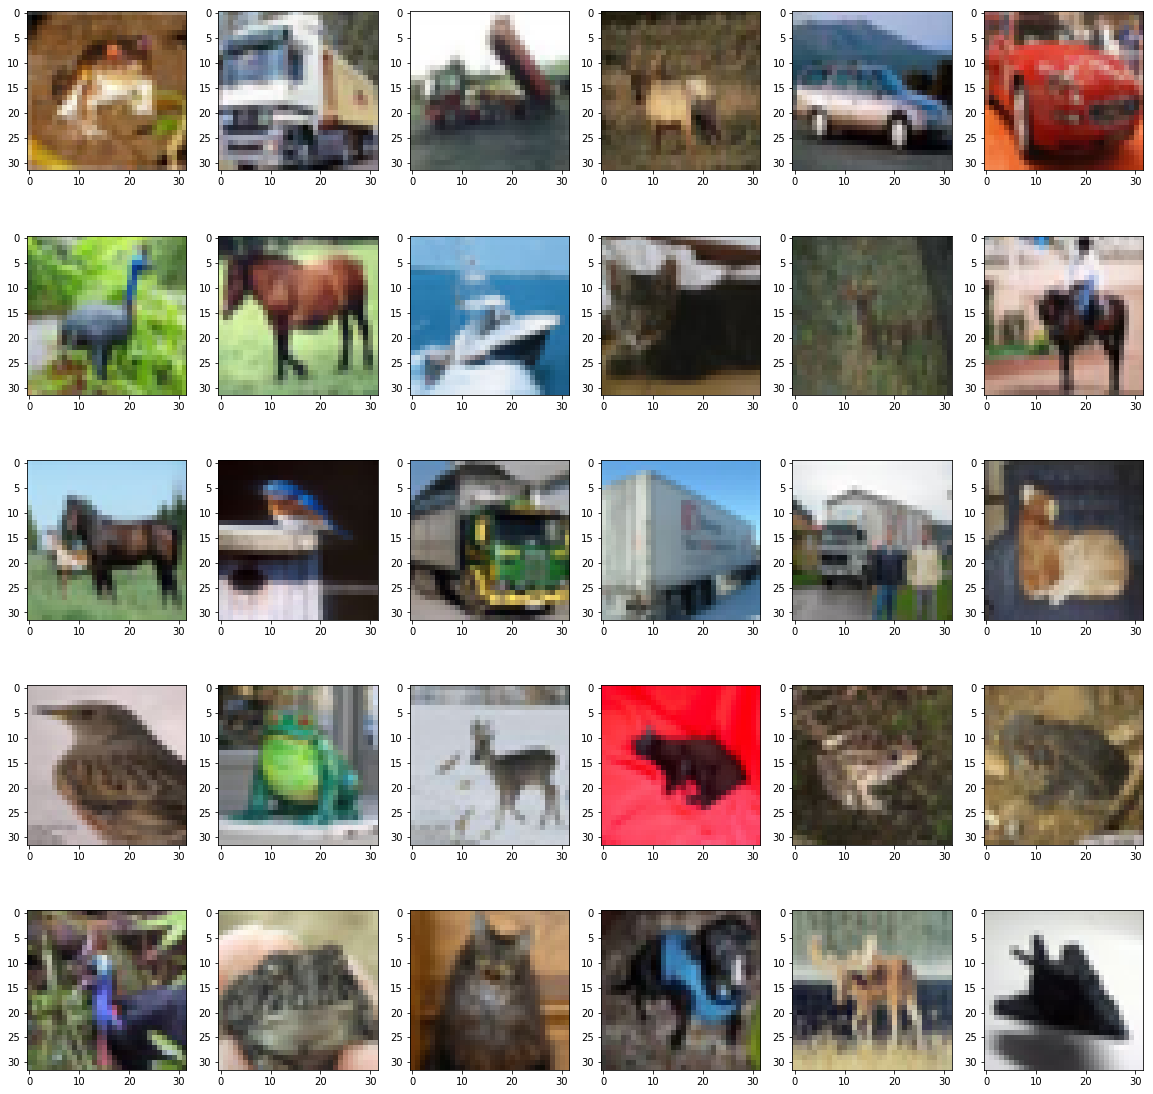

In [ ]:
plt.figure(figsize=(20,20))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.imshow(x_train[i])

Next, let's grab the activations for the layers in ResNet

In [ ]:
layer_outputs = [layer.output for layer in conv_base.layers[2:8]]

activation_model = models.Model(inputs=conv_base.input, outputs=layer_outputs)

Now let's choose an image to visualize with the activations from ResNet

In [ ]:
img = x_train[30]
# img = Image.fromarray(img, 'RGB')
# img.save('outfile.jpg')
# cv2.imwrite('myImage.png',img)

# img = image.load_img('outfile.jpg', target_size=(200, 200))
# img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img, axis=0)
img_tensor /= 255.

In [ ]:
activations = activation_model.predict(img_tensor)

In [ ]:
first_layer_activation = activations[0]

#### Visualization #3

The first image shows the excited activations of the neural network when an image of an airplane is passed through

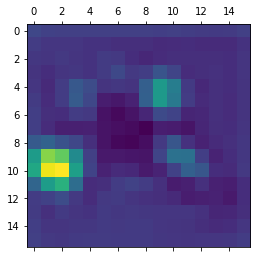

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')
plt.show()

The original image is shown below

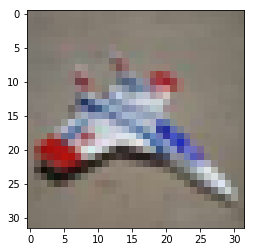

In [ ]:
plt.figure()
plt.imshow(x_train[30])